In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
import os 

In [3]:
images = [((img/255).astype(np.float16), file[:-4].title()) for file in os.listdir("Dataset") for img in np.load(os.path.join("Dataset", file)).reshape(-1, 28, 28, 1)]

In [5]:
df = pd.DataFrame(images, columns=["Image", "Class"])

In [8]:
counts = df['Class'].value_counts()

Text(0.5, 1.0, 'Data Distribution')

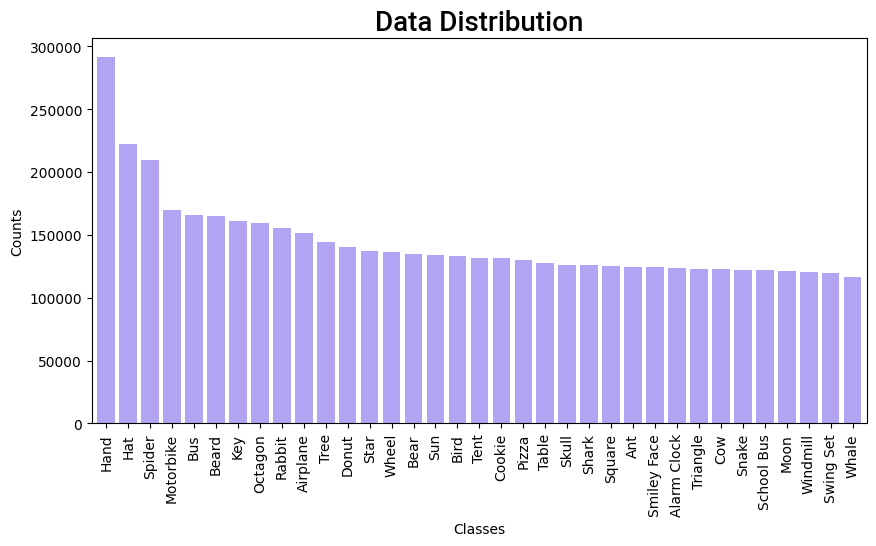

In [9]:
plt.figure(figsize=(10, 5))
counts.plot.bar(color="#B3A3F3", width=0.8)
plt.xlabel("Classes")
plt.ylabel("Counts")
plt.title("Data Distribution", fontdict={'fontsize': 20, 'fontfamily': 'Roboto', 'fontweight': 'semibold'})

In [10]:
df = df.groupby("Class").sample(n=12000, random_state=42)
df = df.reset_index(drop=True)

In [11]:
counts = df['Class'].value_counts()

Text(0.5, 1.0, 'Balanced Data Distribution')

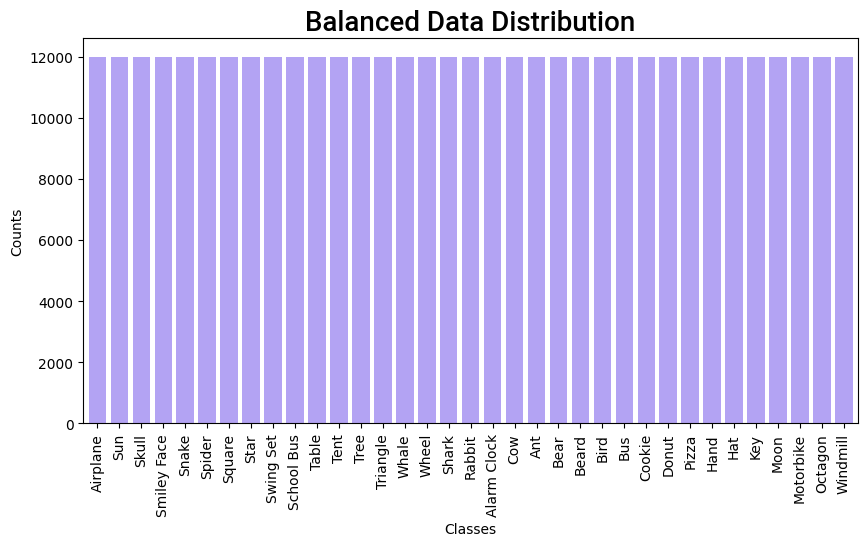

In [12]:
plt.figure(figsize=(10, 5))
counts.plot.bar(color="#B3A3F3", width=0.8)
plt.xlabel("Classes")
plt.ylabel("Counts")
plt.title("Balanced Data Distribution", fontdict={'fontsize': 20, 'fontfamily': 'Roboto', 'fontweight': 'semibold'})

In [13]:
classes = df['Class'].unique()

In [14]:
classes

array(['Airplane', 'Alarm Clock', 'Ant', 'Bear', 'Beard', 'Bird', 'Bus',
       'Cookie', 'Cow', 'Donut', 'Hand', 'Hat', 'Key', 'Moon',
       'Motorbike', 'Octagon', 'Pizza', 'Rabbit', 'School Bus', 'Shark',
       'Skull', 'Smiley Face', 'Snake', 'Spider', 'Square', 'Star', 'Sun',
       'Swing Set', 'Table', 'Tent', 'Tree', 'Triangle', 'Whale', 'Wheel',
       'Windmill'], dtype=object)

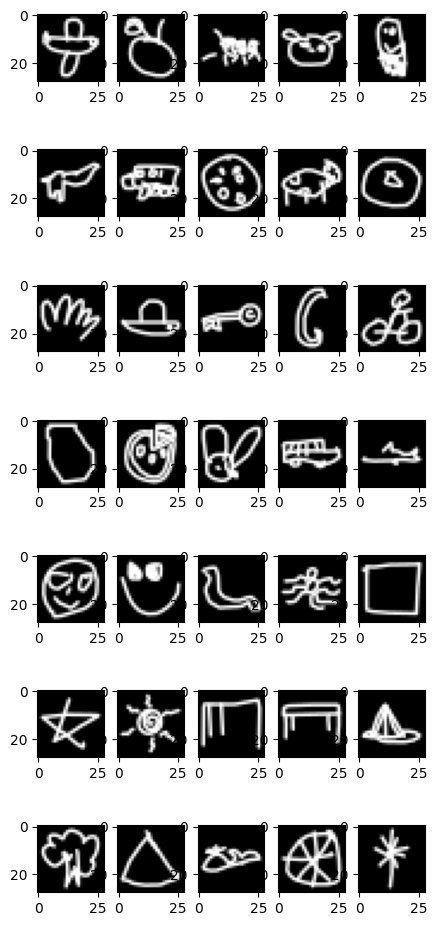

In [ ]:
plt.figure(figsize=(5, 12))
for i, c in enumerate(classes):
    img = df[df['Class'] == c].iloc[0]['Image'].astype(np.float32) * 255
    plt.subplot(7, 5, i+1)
    plt.imshow(Image.fromarray(img.squeeze()))
    plt.grid(False)
    
plt.show()

In [18]:
class_map = {}
for i, c in enumerate(classes):
    class_map[c] = i

In [19]:
df['Label'] = [class_map[c] for c in df['Class']]

In [20]:
df['Encoding'] = list(np.eye(35)[df['Label']])

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
train, test = train_test_split(df, test_size = 0.15, random_state=42, stratify=df['Class'])

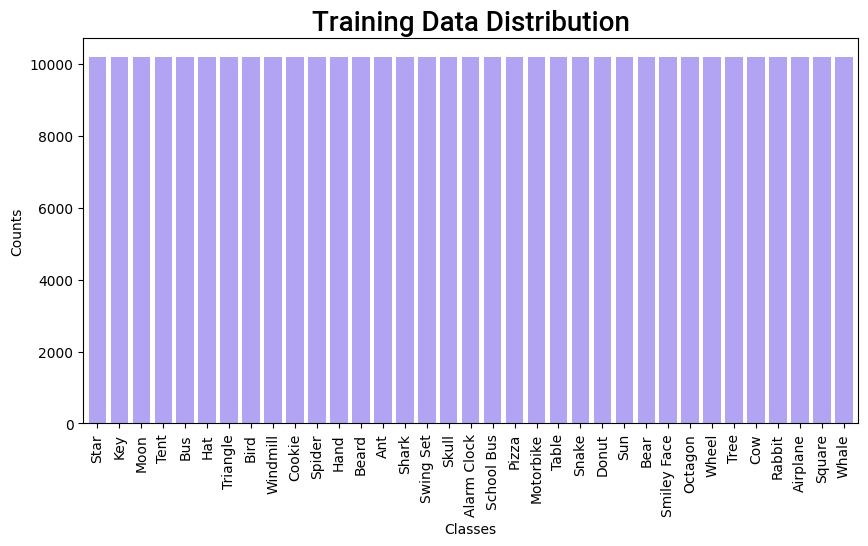

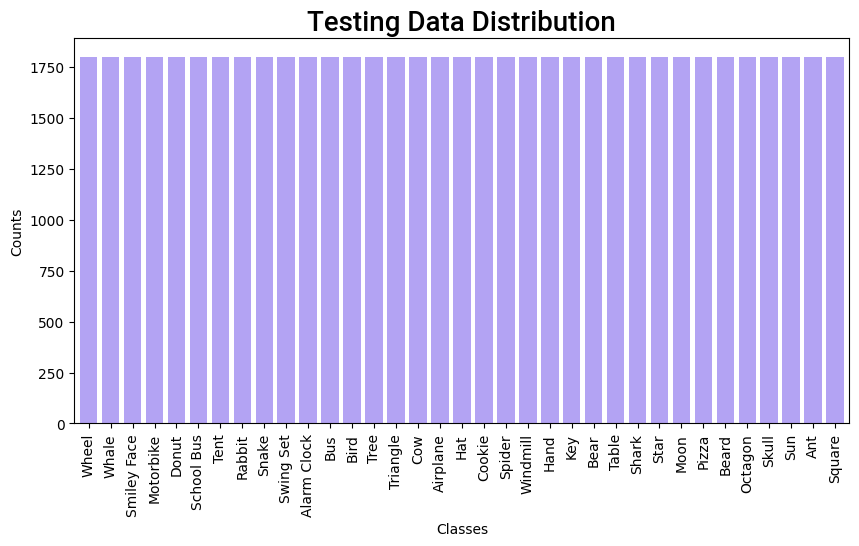

In [23]:
for data, lbl in zip([train, test], ["Training", "Testing"]):

    counts = data['Class'].value_counts()

    plt.figure(figsize=(10, 5))
    counts.plot.bar(color="#B3A3F3", width=0.8)
    plt.xlabel("Classes")
    plt.ylabel("Counts")
    plt.title(f"{lbl} Data Distribution", fontdict={'fontsize': 20, 'fontfamily': 'Roboto', 'fontweight': 'semibold'})
    plt.show()

In [24]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=5820)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [25]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(35, activation='softmax') 
])

In [26]:
from tensorflow.keras.metrics import Precision, Recall, TopKCategoricalAccuracy
from tensorflow.keras.optimizers import Adamax

model.compile(optimizer=Adamax(0.001), loss='categorical_crossentropy', metrics=['accuracy',  TopKCategoricalAccuracy(3), Precision(), Recall()])

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath = "Models/model_epoch_{epoch:02}.keras",
    save_weights_only = False,
    save_best_only = False,
    monitor = 'val_loss',
    mode = 'min',
    verbose = 0
)

In [28]:
import tensorflow.keras.backend as K
K.clear_session()

In [29]:
train.head()

,Image,Class,Label,Encoding
310942,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",Star,25,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
227541,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",School Bus,18,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
175769,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",Motorbike,14,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
338007,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",Table,28,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
264504,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",Snake,22,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [30]:
X_train = np.array(train['Image'].tolist())
y_train = np.array(train['Encoding'].tolist())

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    validation_split=0.2,
    callbacks=[checkpoint],
    batch_size=32
)

Epoch 1/50
8925/8925 [==============================] - 53s 5ms/step - loss: 1.4595 - accuracy: 0.5819 - top_k_categorical_accuracy: 0.7900 - precision: 0.8043 - recall: 0.4279 - val_loss: 0.8366 - val_accuracy: 0.7540 - val_top_k_categorical_accuracy: 0.9058 - val_precision: 0.8721 - val_recall: 0.6645
Epoch 2/50
8925/8925 [==============================] - 45s 5ms/step - loss: 0.9559 - accuracy: 0.7226 - top_k_categorical_accuracy: 0.8890 - precision: 0.8436 - recall: 0.6288 - val_loss: 0.7062 - val_accuracy: 0.7953 - val_top_k_categorical_accuracy: 0.9233 - val_precision: 0.8884 - val_recall: 0.7242
Epoch 3/50
8925/8925 [==============================] - 44s 5ms/step - loss: 0.8327 - accuracy: 0.7586 - top_k_categorical_accuracy: 0.9074 - precision: 0.8607 - recall: 0.6819 - val_loss: 0.6401 - val_accuracy: 0.8105 - val_top_k_categorical_accuracy: 0.9320 - val_precision: 0.8910 - val_recall: 0.7533
Epoch 4/50
8925/8925 [==============================] - 45s 5ms/step - loss: 0.7649 -

In [31]:
import json
with open("Logs/norm-1.json", 'w') as f:
    json.dump(history.history, f)

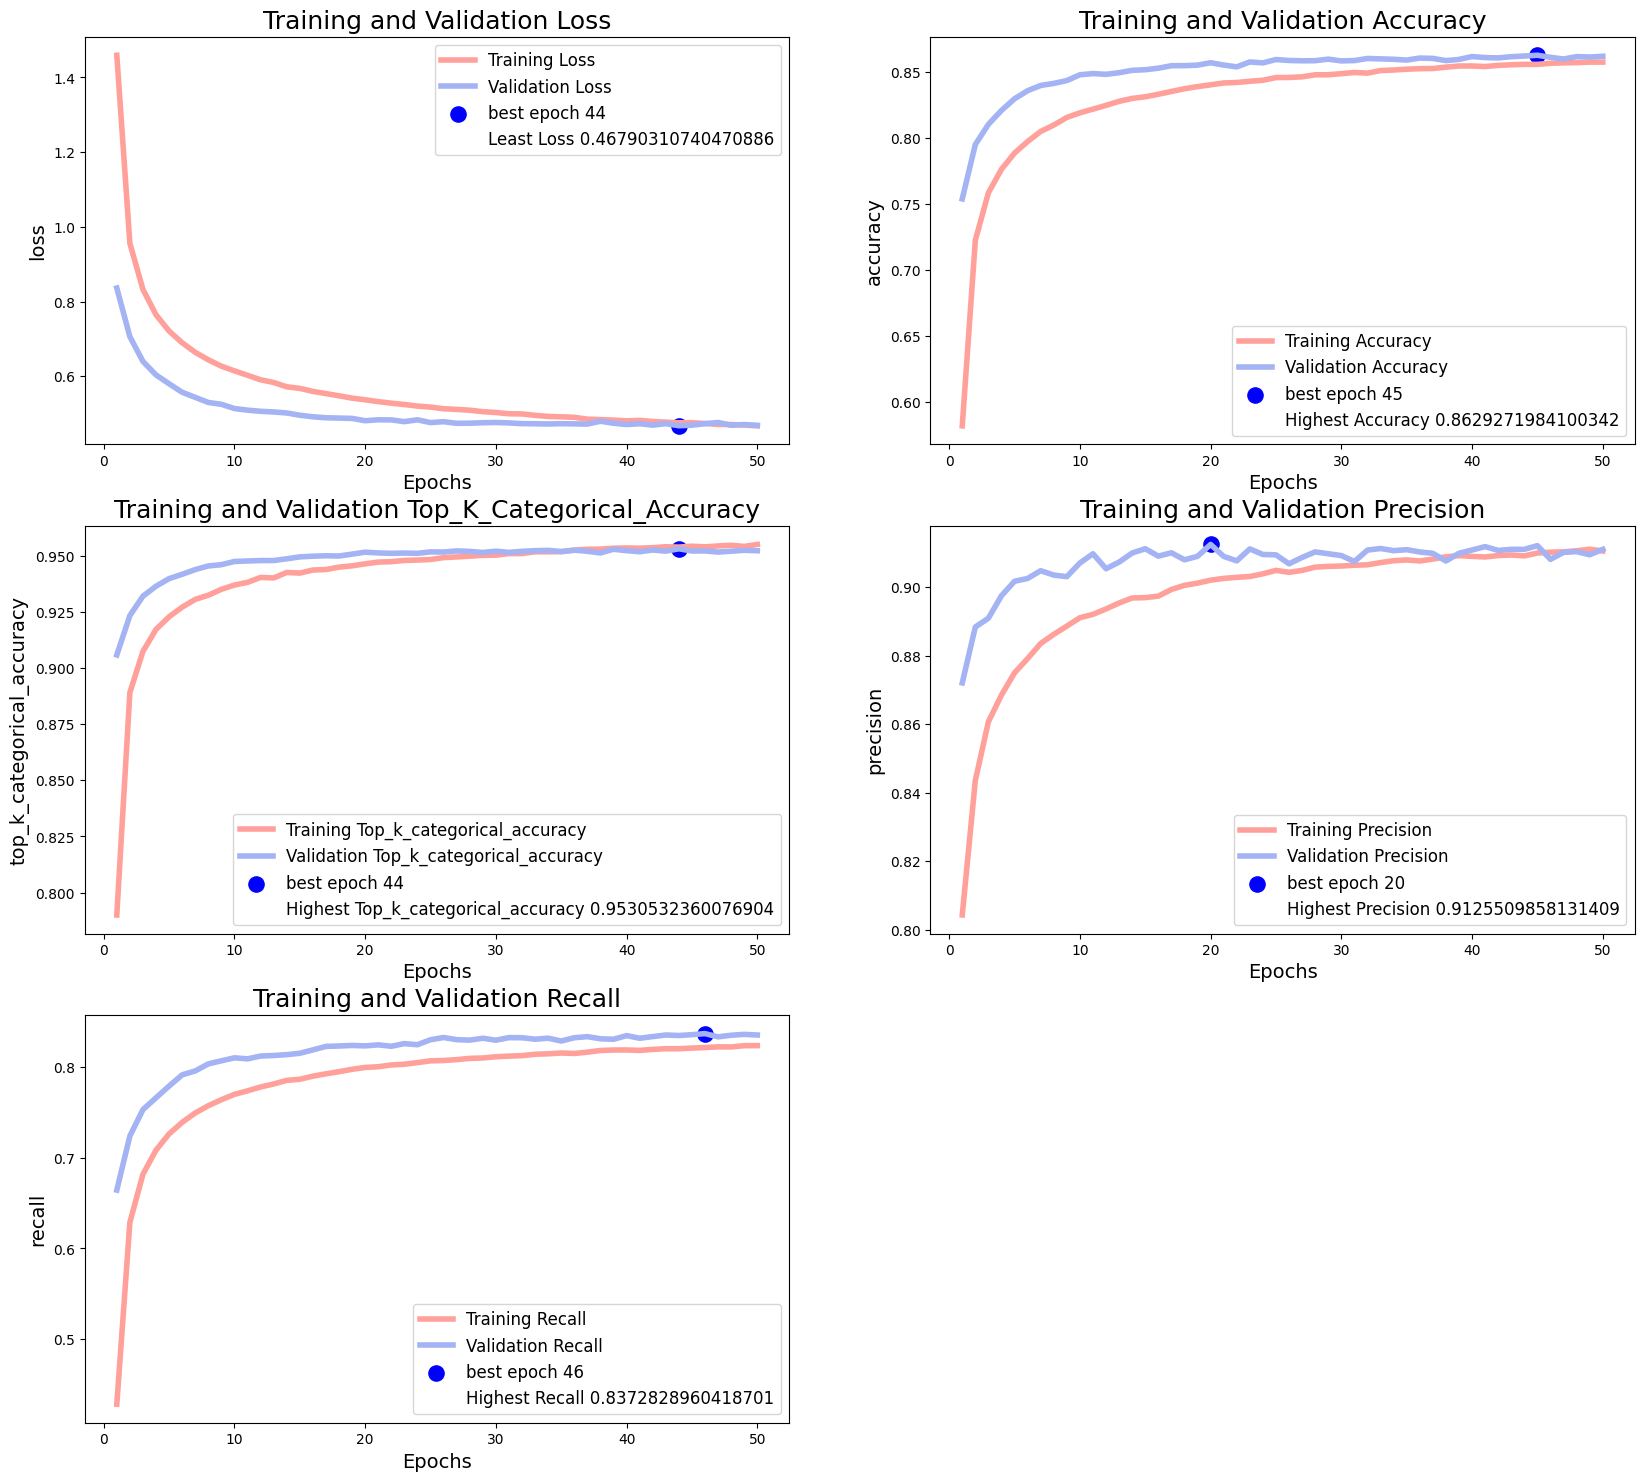

In [35]:
hist = history.history
TRAIN_CLR = '#FFA09B'
VAL_CLR  = '#A3B3F3'
BEST_CLR = 'b'

plt.style.reload_library()
epochs = [i for i in range(1, len(hist['loss'])+1)]
plt.figure(figsize=(20, 18))
for i, m in enumerate(['loss', 'accuracy', 'top_k_categorical_accuracy', 'precision', 'recall']):
    train_values = hist[m]
    val_values = hist[f'val_{m}']
    if m == 'loss':
        best_value = np.min(val_values)
    else:
        best_value = np.max(val_values)
    best_epochs = [j for j, v in enumerate(val_values) if v == best_value]

    plt.subplot(3, 2, i+1)
    plt.plot(epochs, train_values, color=TRAIN_CLR, label = f"Training {m.capitalize()}", linewidth=4)
    plt.plot(epochs, val_values, color=VAL_CLR, label = f"Validation {m.capitalize()}", linewidth=4)
    for e in best_epochs:
        plt.scatter(e+1, best_value, color=BEST_CLR, s=120, label=f'best epoch {e+1}')
    plt.scatter(best_epochs[0]+1, best_value, color=BEST_CLR, s=0, label=f"{'Least' if m == 'loss' else 'Highest'} {m.capitalize()} {best_value}")
    plt.title(f"Training and Validation {m.title()}", fontdict={'size':18})
    plt.xlabel('Epochs', fontdict={'size':14})
    plt.ylabel(m, fontdict={'size':14})
    plt.legend(fontsize=12)

In [36]:
from tensorflow.keras.models import load_model

model = load_model(r"Models\model_epoch_44.keras")

In [37]:
X_test = np.array(test['Image'].tolist()) 
y_test = np.array(test['Encoding'].tolist()) 

In [38]:
y_pred = model.predict(X_test)

1969/1969 [==============================] - 3s 2ms/step


In [39]:
y_pred.argmax(axis=1)

array([33, 33,  7, ..., 32, 18,  8], dtype=int64)

In [40]:
from sklearn.metrics import classification_report

print(classification_report(test['Label'], y_pred.argmax(axis=1), target_names=classes))

              precision    recall  f1-score   support

    Airplane       0.85      0.86      0.86      1800
 Alarm Clock       0.89      0.87      0.88      1800
         Ant       0.80      0.85      0.82      1800
        Bear       0.75      0.70      0.72      1800
       Beard       0.87      0.86      0.87      1800
        Bird       0.78      0.73      0.75      1800
         Bus       0.60      0.72      0.66      1800
      Cookie       0.79      0.90      0.84      1800
         Cow       0.81      0.87      0.84      1800
       Donut       0.94      0.94      0.94      1800
        Hand       0.93      0.92      0.93      1800
         Hat       0.93      0.89      0.91      1800
         Key       0.84      0.89      0.86      1800
        Moon       0.87      0.76      0.81      1800
   Motorbike       0.90      0.90      0.90      1800
     Octagon       0.87      0.91      0.89      1800
       Pizza       0.81      0.75      0.78      1800
      Rabbit       0.85    